In [1]:
import torch
import copy
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
 
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 8
learning_rate = 0.0015
num_epochs = 800

normal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\normal'
abnormal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\abnormal'


In [4]:
normal_set = datasets.ImageFolder(
    normal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

abnormal_set = datasets.ImageFolder(
    abnormal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

train_dataset, test_dataset = torch.utils.data.random_split(normal_set, [220, 80])

In [5]:
def make_dir(args):    
    import os

    MODEL_DIR = f"FL_model/client = {args.num_clients}"
    try:
        os.makedirs(MODEL_DIR)
    except FileExistsError:
        print('Directories not created because they already exist')

In [6]:
def list_np_tensor(param_data):
    data = []
    for i in range(np.size(param_data, 0)):
        data.append(np.concatenate((param_data[i]['net.0.weight'].cpu().numpy(), np.expand_dims(param_data[i]['net.0.bias'].cpu().numpy(), axis=1)),axis=1))
    
    data = torch.Tensor(data)
    return data
    
def save_param(param_data):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    dtf = pd.DataFrame(dt)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def save_param_with_round(param_data, round_list, args):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    
    round_tensor = torch.tensor(round_list).view(-1, 1)
    dt_r = torch.cat((dt, round_tensor), dim=1)
    
    dtf = pd.DataFrame(dt_r)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def load_data(args):    
    ldt = pd.read_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    ldt = ldt.values
    ldt = np.delete(ldt, 0, 1)
    return ldt

def data_split(args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

In [7]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size = 2, stride = 2, padding=0),
            nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)      
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        
        return output

In [8]:
def define_client(partition, r, num, args):
    train_loader = DataLoader(partition['train'][num], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = ConvAutoEncoder().to(device)
    else:
        net = torch.load(args.INIT_PATH)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

In [9]:
def train(net, train_loader, criterion, optimizer, args):
    
    train_loss = 0
    for epoch in range(args.num_epochs):        
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
    train_loss /= len(train_loader)*args.num_epochs

    torch.save(net, args.NET_PATH)
    return net, train_loss

In [10]:
def Fed_AVG(model, client_model_list, args):
    model.train()
    local_weights = []

    for i in range(args.num_clients):
        local_weights.append(copy.deepcopy(client_model_list[i].state_dict()))
    w_avg = copy.deepcopy(local_weights[0]) #type of w_avg : <class 'collections.OrderedDict'>

    for key in w_avg.keys():
        for i in range(1,len(local_weights)):
            w_avg[key] += local_weights[i][key]
        w_avg[key] = torch.div(w_avg[key], len(local_weights))

    global_weights = w_avg
    model.load_state_dict(global_weights)
    torch.save(model, args.INIT_PATH)

    return model, local_weights

In [11]:
def test(model, partition, criterion, args):
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=True)
    model.eval()

    loss = 0
    round_loss = 0
            
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)
        loss += criterion(outputs, images).item()
    
    round_loss = loss / len(test_loader)
 
    return round_loss

In [12]:
def experiment(partition, args):
    model = ConvAutoEncoder().to(device)
    torch.save(model, args.INIT_PATH)

    round_losses = []
    round_client_losses = []
    param_data = []
    round_list = []

    for r in range(args.num_rounds):
        train_losses = []
        client_model_list = []
        
        for num in range(args.num_clients):
            setattr(args, 'NET_PATH', f'FL_model/client = {args.num_clients}/client_{num}.pth')
            
            net, train_loader, criterion, optimizer = define_client(partition, r, num, args)
            net, train_loss = train(net, train_loader, criterion, optimizer, args)
            
            client_model_list.append(net)
            train_losses.append(train_loss)
            
        model, local_weights = Fed_AVG(model, client_model_list, args)
        round_loss = test(model, partition, criterion, args)

        print(f'[Round {r}] Round Loss: {round_loss:.4f} Client1 Loss: {train_losses[0]:.4f} Client2 Loss: {train_losses[1]:.4f}')

        round_losses.append(round_loss)
        round_client_losses.append(train_losses)
        round_list.append([r, r, r])
        param_data += local_weights
        
    return round_losses, round_client_losses, round_list, param_data

In [13]:
def plot_loss(round_loss, round_client_losses):
    plt.plot(round_loss, label='Avg')
    plt.plot(np.array(round_client_losses)[:,0], label='Client1')
    plt.plot(np.array(round_client_losses)[:,1], label='Client2')
    plt.grid()
    plt.legend()

    plt.show()

Directories not created because they already exist
[Round 0] Round Loss: 0.0483 Client1 Loss: 0.0587 Client2 Loss: 0.0402
[Round 1] Round Loss: 0.0478 Client1 Loss: 0.0478 Client2 Loss: 0.0483
[Round 2] Round Loss: 0.0472 Client1 Loss: 0.0474 Client2 Loss: 0.0477
[Round 3] Round Loss: 0.0466 Client1 Loss: 0.0469 Client2 Loss: 0.0470
[Round 4] Round Loss: 0.0457 Client1 Loss: 0.0461 Client2 Loss: 0.0465
[Round 5] Round Loss: 0.0446 Client1 Loss: 0.0453 Client2 Loss: 0.0456
[Round 6] Round Loss: 0.0433 Client1 Loss: 0.0436 Client2 Loss: 0.0441
[Round 7] Round Loss: 0.0417 Client1 Loss: 0.0423 Client2 Loss: 0.0428
[Round 8] Round Loss: 0.0399 Client1 Loss: 0.0407 Client2 Loss: 0.0412
[Round 9] Round Loss: 0.0379 Client1 Loss: 0.0389 Client2 Loss: 0.0392
[Round 10] Round Loss: 0.0357 Client1 Loss: 0.0365 Client2 Loss: 0.0371
[Round 11] Round Loss: 0.0334 Client1 Loss: 0.0344 Client2 Loss: 0.0348
[Round 12] Round Loss: 0.0311 Client1 Loss: 0.0321 Client2 Loss: 0.0324
[Round 13] Round Loss: 

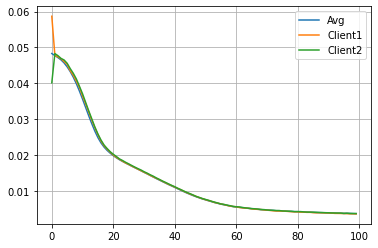

In [14]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.num_epochs = 5
args.num_rounds = 100
args.num_clients = 2
args.lr = 0.0001

args.batch_size = 100

make_dir(args)

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'

train_set_list = data_split(args)
partition = {'train':train_set_list, 'test':test_dataset}
    
round_loss, round_client_losses, round_list, param_data = experiment(partition, args)
plot_loss(round_loss, round_client_losses)

In [18]:
model = ConvAutoEncoder()
model = torch.load(args.INIT_PATH)
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=batch_size,shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')

Normal loss: 0.00380064104070985
Abnormal loss: 0.0109149138584818


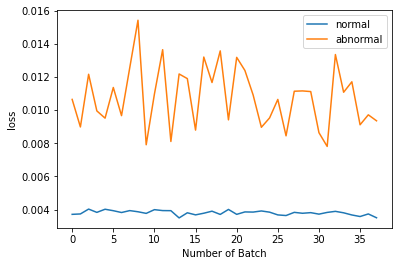

In [21]:
plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

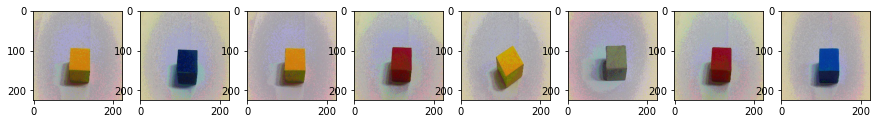

In [22]:
abnormal_images, abnormal_labels = next(iter(abnormal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(batch_size), abnormal_images, abnormal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, batch_size, i+1)
    ax.imshow(numpy_img)
plt.show()

C:\Users\WorkStation\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([8, 3, 224, 224])) that is different to the input size (torch.Size([3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.015744982287287712
0.010180007666349411
0.015766428783535957
0.012609187513589859
0.015444241464138031
0.012518799863755703
0.013055368326604366
0.010533709079027176


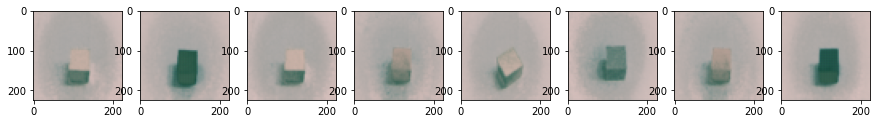

In [23]:
model.cpu()
abnormal_output = model(abnormal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(batch_size), abnormal_output, abnormal_labels):
    loss = criterion(img, abnormal_images)
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, batch_size, i+1)
    ax.imshow(numpy_img)
plt.show()